In [1]:
# Import required libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from skimage import transform
from skimage import exposure
from skimage import io
from sklearn.utils import shuffle

np.random.seed(42)
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
# Store data, labels in the list
cur_path = "traffic_dataset"
data = []
labels = []
num_classes = len(os.listdir(cur_path + "\Train"))
print(num_classes)

43


In [3]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [4]:
# Retrieving the images and their labels 
for i in range(num_classes):
    path = os.path.join(cur_path,'train',str(i))
    images = os.listdir(path)
    
# Preprocess the images
    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((224,224))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")
            

In [5]:
# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)

(39209, 224, 224, 3) (39209,)


In [6]:
#Shuffling the training data
shuffle_indexes = np.arange(data.shape[0])
np.random.shuffle(shuffle_indexes)
data = data[shuffle_indexes]
labels = labels[shuffle_indexes]

In [7]:
# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 224, 224, 3) (7842, 224, 224, 3) (31367,) (7842,)


In [8]:
# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [10]:
#Building the model
model = Sequential()
base_model = ResNet50(input_shape=X_train.shape[1:],include_top=False, weights='imagenet')

#Don't train existing weights
for layer in base_model.layers:
    layer.trainable = False

In [11]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(512,activation='relu'))
add_model.add(BatchNormalization())
add_model.add(Dense(43,activation='softmax'))
model = Model(inputs=base_model.input, outputs=add_model(base_model.output))


learning_rate = 0.01
batch_size = 32
opt = Adam(learning_rate=learning_rate)

# tell the model what cost and optimization method to use
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

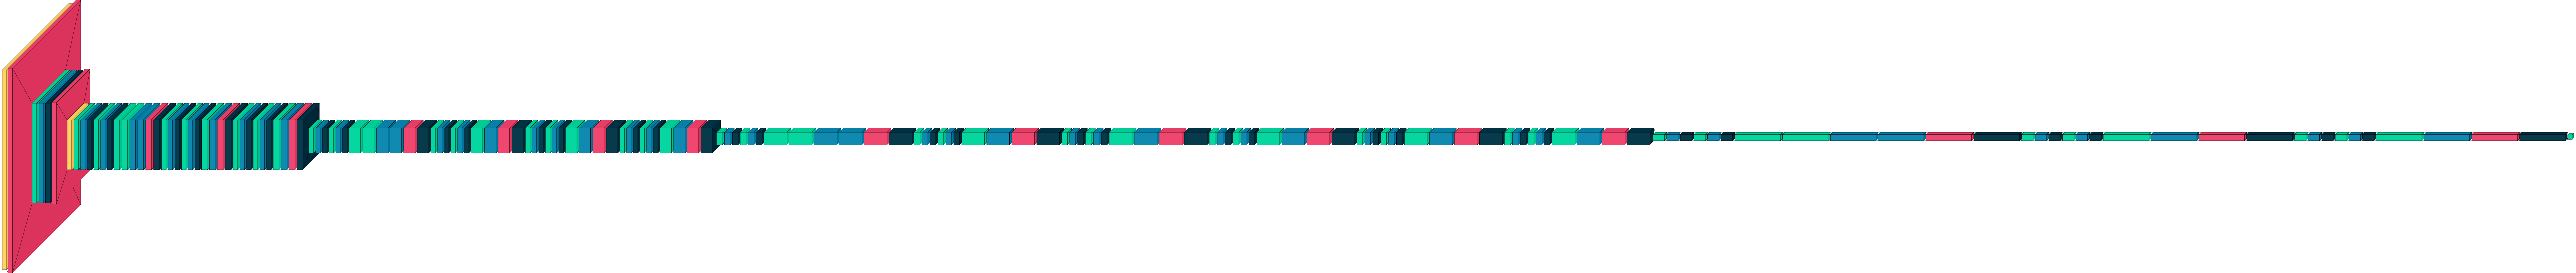

In [12]:
import visualkeras
visualkeras.layered_view(model)

In [13]:
epochs = 10

history = model.fit(X_train,y_train,batch_size=batch_size, validation_data=(X_test,y_test), steps_per_epoch=X_train.shape[0]//batch_size, epochs=epochs)


Epoch 1/10
980/980 [==============================] - 1295s 1s/step - loss: 0.4199 - accuracy: 0.8808 - val_loss: 0.1129 - val_accuracy: 0.9709
Epoch 2/10
980/980 [==============================] - 1274s 1s/step - loss: 0.0730 - accuracy: 0.9771 - val_loss: 0.1483 - val_accuracy: 0.9592
Epoch 3/10
980/980 [==============================] - 1270s 1s/step - loss: 0.0620 - accuracy: 0.9812 - val_loss: 0.1918 - val_accuracy: 0.9514
Epoch 4/10
980/980 [==============================] - 1277s 1s/step - loss: 0.0559 - accuracy: 0.9844 - val_loss: 0.1149 - val_accuracy: 0.9737
Epoch 5/10
980/980 [==============================] - 1323s 1s/step - loss: 0.0470 - accuracy: 0.9881 - val_loss: 0.2298 - val_accuracy: 0.9591
Epoch 6/10
980/980 [==============================] - 1313s 1s/step - loss: 0.0383 - accuracy: 0.9896 - val_loss: 0.1617 - val_accuracy: 0.9707
Epoch 7/10
980/980 [==============================] - 1290s 1s/step - loss: 0.0346 - accuracy: 0.9908 - val_loss: 0.1924 - val_accuracy:

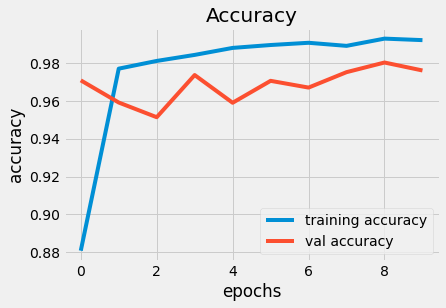

In [14]:
# Plotting graphs for Accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

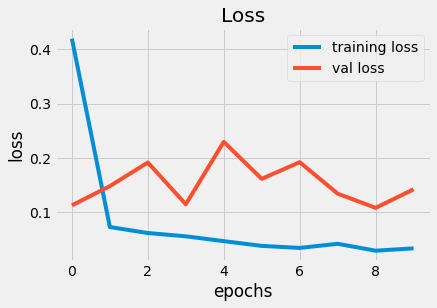

In [15]:
# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
# Testing accuracy on test dataset
from sklearn.metrics import accuracy_score

y_test = pd.read_csv("traffic_dataset\Test.csv")

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

In [17]:
for img in imgs:
    image = Image.open(cur_path + '\\'+ img)
    image = image.resize((224,224))
    data.append(np.array(image))
    
X_test=np.array(data)

pred = np.argmax(model.predict(X_test), axis=-1)

In [18]:
#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

0.8483768804433888


In [20]:
model.save('traffic_classifier_resnet.h5')